# Case Study

## Goal 

Buying parts can become very messy very quickly in the whole supply chain cycle! 
Data science can be extremely useful to automatically organize the items in categories so 
that they can be easily found by the engineers for the product that they are building. 
  
The goal of this challenge is to look at product purchase history and create categories of items that 
are likely to be bought together and, therefore, should belong to the same section. 

## Challenge Description 

In the current version of the supply chain, we have manually grouped the items into a few categories intuitively. 

However, they now have a lot of data about product purchase history. Therefore, they would like to 
put the data into use!

This is what they asked you to do:

* The company founder wants to meet with some of the best products to go through a focused demand management. You are asked to send the ID of the following products to the founder:

    * Top 5% percentile of the products who bought the most items overall in their lifetime for each item 
    * The products who bought that item the most
    * Which are the top 3 most expensive products to manufacture?


* Find out the correlation between Lead Time and Cost. Do items with higher Lead Time cost more than the items with Low Lead Time?

* If we want to focus on reducing Lead Time of items by placing them on certain specialty programs. Which parts should we focus on?
  
* Cluster items based on products co-purchase history. That is, create clusters of items that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

## Data Definition

The 2 tables are: 

"item_to_id" - for each item, it gives the corresponding id

Columns:
* Item_name : the name of the item 
* Item_id : the id of the item. Can be joined to the id in the other table. It is unique by item 
* Item_cost : cost of the item in USD 
* Item_lt : Lead time of the item in days  
  
"purchase_history" - for each product purchase, the items bought

Columns: 
* product_id : the id of the product. 
* id : comma-separated list of items bought together in that transaction.

In [106]:
# Importing needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.cluster import KMeans

In [105]:
ids = pd.read_csv('item_to_id.csv')
purchases = pd.read_csv('purchase_history.csv')

In [5]:
ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Item_name  48 non-null     object 
 1   Item_id    48 non-null     int64  
 2   cost       48 non-null     float64
 3   lead_time  48 non-null     int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1.6+ KB


In [6]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  39474 non-null  int64 
 1   id          39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [3]:
ids.head()

,Item_name,Item_id,cost,lead_time
0,CABLE 1,43,34.11,71
1,CABLE 2,23,366.26,72
2,CABLE 3,38,20.19,65
3,CABLE 4,9,64.02,89
4,HEXÊNUT,39,2.50,46


In [4]:
purchases.head()

,product_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


## Question 1

### Return the Product IDs of Top 5% percentile of the products who bought the most items overall in their lifetime for each item.

In [27]:
# Splitting IDs by comma into list
purchases['split_ids'] = purchases['id'].str.split(',')

# Counting number of IDs in each product order
purchases['item_quantity'] = purchases['split_ids'].str.len()

In [28]:
purchases.head()

,product_id,id,split_ids,item_quantity
0,222087,"27,26","[27, 26]",2
1,1343649,"6,47,17","[6, 47, 17]",3
2,404134,"18,12,23,22,27,43,38,20,35,1","[18, 12, 23, 22, 27, 43, 38, 20, 35, 1]",10
3,1110200,"9,23,2,20,26,47,37","[9, 23, 2, 20, 26, 47, 37]",7
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4...","[31, 18, 5, 13, 1, 21, 48, 16, 26, 2, 44, 32, ...",20


In [45]:
# Exploding split_ids column to create one row for each product/item combination
updated_purchases = purchases.explode('split_ids')
updated_purchases

,product_id,id,split_ids,item_quantity
0,222087,"27,26",27,2
0,222087,"27,26",26,2
1,1343649,"6,47,17",6,3
1,1343649,"6,47,17",47,3
1,1343649,"6,47,17",17,3
...,...,...,...,...
39473,517744,"39,40,20,3,10,42,38,43,28,25,13",38,11
39473,517744,"39,40,20,3,10,42,38,43,28,25,13",43,11
39473,517744,"39,40,20,3,10,42,38,43,28,25,13",28,11
39473,517744,"39,40,20,3,10,42,38,43,28,25,13",25,11


In [98]:
updated_purchases.groupby(['split_ids', 'product_id']).sum('item_quantity').reset_index()

,split_ids,product_id,item_quantity
0,1,223,7
1,1,323,15
2,1,394,10
3,1,453,8
4,1,553,11
...,...,...,...
290553,48,1499461,12
290554,48,1499563,14
290555,48,1499778,3
290556,48,1499797,10


In [36]:
purchases.groupby(['product_id']).sum(['item_quantity']).reset_index().sort_values('item_quantity', ascending=False)

,product_id,item_quantity
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63
...,...,...
2200,134092,1
7867,470804,1
287,16919,1
5947,358344,1


In [358]:
# Converting Items IDs to integer values
updated_purchases['split_ids'] = updated_purchases['split_ids'].astype(int)

In [359]:
# Grouping dataset by Item IDs and counting number of times a Product ordered that Item
q1_grouping = updated_purchases.groupby(['split_ids'])['product_id'].value_counts().reset_index(name = 'count')
q1_grouping

,split_ids,product_id,count
0,1,31625,4
1,1,68836,4
2,1,540483,4
3,1,1091637,4
4,1,1301034,4
...,...,...,...
290553,48,1499461,1
290554,48,1499563,1
290555,48,1499778,1
290556,48,1499797,1


In [361]:
# Filtering grouped dataset for Top 5% of Products by count for each Item
q1_answer = q1_grouping[q1_grouping['count'] >= q1_grouping.groupby('split_ids')['count'].transform('quantile', 0.95)]
q1_answer

,split_ids,product_id,count
0,1,31625,4
1,1,68836,4
2,1,540483,4
3,1,1091637,4
4,1,1301034,4
...,...,...,...
285600,48,1493630,2
285601,48,1494796,2
285602,48,1497111,2
285603,48,1498357,2


In [387]:
q1_answer[['split_ids', 'product_id']]

,split_ids,product_id
0,1,31625
1,1,68836
2,1,540483
3,1,1091637
4,1,1301034
...,...,...
285600,48,1493630
285601,48,1494796
285602,48,1497111
285603,48,1498357


In [369]:
pd.set_option('max_colwidth', 100)

In [370]:
# Returning Top 5% of Product IDs by Item ID
q1_answer.groupby(['split_ids']).agg({'product_id': lambda x: x.tolist()})

,product_id
split_ids,
1,"[31625, 68836, 540483, 1091637, 1301034, 4359, 19126, 64998, 115849, 139064, 154849, 167594, 172..."
2,"[31625, 269335, 19126, 64998, 150289, 367872, 531318, 540483, 578216, 765694, 820788, 878161, 90..."
3,"[154960, 593439, 1147269, 1433188, 19126, 80215, 85020, 114406, 116305, 364868, 414118, 432842, ..."
4,"[5289, 73071, 432842, 4359, 8959, 10556, 14710, 18025, 32164, 50548, 65259, 65325, 69489, 69912,..."
5,"[217277, 397623, 414416, 1392068, 51969, 65259, 124396, 134809, 144516, 149818, 151746, 162845, ..."
6,"[334664, 1151741, 19126, 32527, 180541, 190771, 205638, 210204, 269335, 292805, 304701, 337954, ..."
7,"[175865, 312711, 360336, 811299, 1147990, 1494252, 1833, 6139, 21929, 32527, 39770, 48967, 57733..."
8,"[151926, 238761, 269836, 297980, 300878, 423287, 478446, 489063, 540483, 578216, 587316, 722795,..."
9,"[269335, 397623, 1271258, 1310896, 10556, 30403, 50451, 102476, 131026, 215286, 224107, 233575, ..."


## Question 2

### Return the Product IDs of the products who bought that item the most (from Q1).

In [373]:
q1_answer

,split_ids,product_id,count
0,1,31625,4
1,1,68836,4
2,1,540483,4
3,1,1091637,4
4,1,1301034,4
...,...,...,...
285600,48,1493630,2
285601,48,1494796,2
285602,48,1497111,2
285603,48,1498357,2


In [388]:
q2_answer = q1_grouping[q1_grouping['count'] >= q1_grouping.groupby('split_ids')['count'].transform('quantile', 1)]
q2_answer

,split_ids,product_id,count
0,1,31625,4
1,1,68836,4
2,1,540483,4
3,1,1091637,4
4,1,1301034,4
...,...,...,...
285258,48,1167089,3
285259,48,1169085,3
285260,48,1213479,3
285261,48,1280108,3


In [389]:
# Returning Product IDs that bought the most of each Item by Item ID
q2_answer.groupby(['split_ids']).agg({'product_id': lambda x: x.tolist()})

,product_id
split_ids,
1,"[31625, 68836, 540483, 1091637, 1301034]"
2,"[31625, 269335]"
3,"[154960, 593439, 1147269, 1433188]"
4,"[5289, 73071, 432842]"
5,"[217277, 397623, 414416, 1392068]"
6,"[334664, 1151741]"
7,"[175865, 312711, 360336, 811299, 1147990, 1494252]"
8,"[151926, 238761, 269836, 297980, 300878, 423287, 478446, 489063, 540483, 578216, 587316, 722795,..."
9,"[269335, 397623, 1271258, 1310896]"


## Question 3

### Return the Product IDs of the top 3 most expensive products to manufacture.

In [49]:
updated_purchases.head()

,product_id,id,split_ids,item_quantity
0,222087,"27,26",27,2
0,222087,"27,26",26,2
1,1343649,"6,47,17",6,3
1,1343649,"6,47,17",47,3
1,1343649,"6,47,17",17,3


In [53]:
updated_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319995 entries, 0 to 39473
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_id     319995 non-null  int64 
 1   id             319995 non-null  object
 2   split_ids      319995 non-null  object
 3   item_quantity  319995 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 12.2+ MB


In [50]:
ids.head()

,Item_name,Item_id,cost,lead_time
0,CABLE 1,43,34.11,71
1,CABLE 2,23,366.26,72
2,CABLE 3,38,20.19,65
3,CABLE 4,9,64.02,89
4,HEXÊNUT,39,2.50,46


In [390]:
# Merging Updated Purchases and IDs tables together on Item ID
merged_data = updated_purchases.merge(ids, left_on = 'split_ids', right_on = 'Item_id')
merged_data.head()

,product_id,id,split_ids,item_quantity,Item_name,Item_id,cost,lead_time,cost_per_day
0,222087,"27,26",27,2,HEATER/CHILLERÊSYSTEM,27,7027.85,28,250.994643
1,404134,"18,12,23,22,27,43,38,20,35,1",27,10,HEATER/CHILLERÊSYSTEM,27,7027.85,28,250.994643
2,987613,"27,1,3,2,11,45,10,44,15",27,9,HEATER/CHILLERÊSYSTEM,27,7027.85,28,250.994643
3,60201,"26,28,13,39,27,22,48,18,16,17,32",27,11,HEATER/CHILLERÊSYSTEM,27,7027.85,28,250.994643
4,1166671,"17,20,27",27,3,HEATER/CHILLERÊSYSTEM,27,7027.85,28,250.994643


#### Total Cost

In [65]:
# Returning Product IDs of the top 3 most expensive products to manufacture
merged_data.groupby(['product_id'])['cost'].sum().sort_values(ascending = False).head(3)

product_id
1198106    478797.76
845633     402144.23
151926     387776.01
Name: cost, dtype: float64

#### Future Approaches to Consider
* Most expensive products on average
* Most expensive products without outlier costs

In [394]:
merged_data.groupby(['product_id']).agg({'split_ids': lambda x: x.tolist(), 'cost': 'mean'})

,split_ids,cost
product_id,,
47,"[23, 2, 13, 16, 44, 45, 15, 25, 28, 46, 3, 24, 4]",8219.945385
68,"[6, 17, 23, 42, 25, 10, 19, 39]",1029.802500
113,"[43, 38, 9, 21, 32, 15, 25, 46, 3, 30, 33]",743.881818
123,"[27, 18, 10, 4]",4317.220000
223,"[6, 17, 22, 38, 35, 1, 2, 32, 29, 45, 41]",9530.540909
...,...,...
1499730,"[45, 25]",43404.565000
1499778,"[26, 6, 2, 48, 32, 42, 14]",281.402857
1499797,"[6, 37, 13, 48, 44, 45, 11, 3, 39, 34]",9898.372000


In [392]:
# Returning Product IDs of the top 3 most expensive products to manufacture
merged_data.groupby(['product_id'])['cost'].mean().sort_values(ascending = False).head(3)

product_id
409473     86388.77
634382     86388.77
1119150    86388.77
Name: cost, dtype: float64

## Question 4

### Find out the correlation between Lead Time and Cost. Do items with higher Lead Time cost more than the items with Low Lead Time?

In [66]:
ids.head()

,Item_name,Item_id,cost,lead_time
0,CABLE 1,43,34.11,71
1,CABLE 2,23,366.26,72
2,CABLE 3,38,20.19,65
3,CABLE 4,9,64.02,89
4,HEXÊNUT,39,2.50,46


#### Removing Outliers

In [412]:
# Calculating z scores for costs and lead times 
ids['cost_zscore'] = stats.zscore(ids['cost'])
ids['cost_zscore'] = round(ids['cost_zscore'], 2)

ids['lead_time_zscore'] = stats.zscore(ids['lead_time'])
ids['lead_time_zscore'] = round(ids['lead_time_zscore'], 2)

ids.head()

,Item_name,Item_id,cost,lead_time,cost_per_day,cost_zscore,lead_time_zscore
0,CABLE 1,43,34.11,71,0.480423,-0.26,0.19
1,CABLE 2,23,366.26,72,5.086944,-0.23,0.22
2,CABLE 3,38,20.19,65,0.310615,-0.26,0.03
3,CABLE 4,9,64.02,89,0.719326,-0.26,0.66
4,HEXÊNUT,39,2.50,46,0.054348,-0.26,-0.47


In [414]:
# Outliers in cost and lead time data (> 3 SDs from mean)
ids[(np.abs(ids['cost_zscore']) > 3) | (np.abs(ids['lead_time_zscore']) > 3)]

,Item_name,Item_id,cost,lead_time,cost_per_day,cost_zscore,lead_time_zscore
33,OXIDE GAS PANEL,45,86388.77,41,2107.043171,6.66,-0.6


In [423]:
# Removing identified outliers from dataset before calculating correlation
ids_to_correlate = ids[(np.abs(ids['cost_zscore']) <= 3) & (np.abs(ids['lead_time_zscore']) <= 3)]
ids_to_correlate.head()

,Item_name,Item_id,cost,lead_time,cost_per_day,cost_zscore,lead_time_zscore
0,CABLE 1,43,34.11,71,0.480423,-0.26,0.19
1,CABLE 2,23,366.26,72,5.086944,-0.23,0.22
2,CABLE 3,38,20.19,65,0.310615,-0.26,0.03
3,CABLE 4,9,64.02,89,0.719326,-0.26,0.66
4,HEXÊNUT,39,2.50,46,0.054348,-0.26,-0.47


In [431]:
# Calculating Pearson's correlation between item lead time and cost
# Pearson's correlation coefficient measures the strength and direction of the linear relationship between two continuous variables (from -1 to +1)
q4_answer = round(ids_to_correlate['lead_time'].corr(ids['cost']), 6)

In [427]:
corr = ids_to_correlate[['cost', 'lead_time']].corr()
corr.style.background_gradient(cmap='coolwarm')

,cost,lead_time
cost,1.000000,0.122163
lead_time,0.122163,1.000000


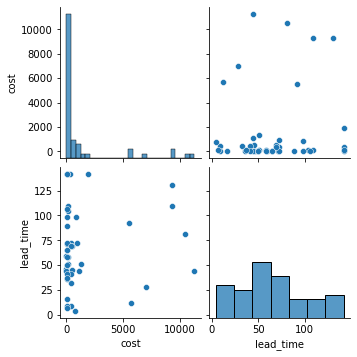

In [428]:
# Plotting correlation of data without outliers
sns.pairplot(ids_to_correlate[['cost', 'lead_time']]);

In [437]:
print("The value of the Pearson correlation coefficient between item lead time and cost is {}. This indicates a slightly positive correlation between the two variables, meaning that when lead time increases cost will increase as well.".format(q4_answer))

The value of the Pearson correlation coefficient between item lead time and cost is 0.122163. This indicates a slightly positive correlation between the two variables, meaning that when lead time increases cost will increase as well.


Based on this information, items with higher lead time cost slightly more than items with low lead time.

However, since the correlation coefficient is so close to 0, it can be concluded that the two fields have virtually a nonlinear correlation.

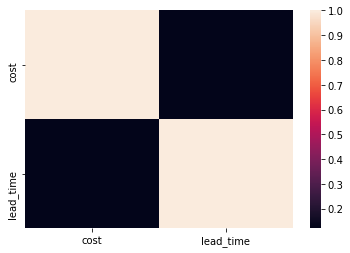

In [425]:
sns.heatmap(ids_to_correlate[['cost', 'lead_time']].corr());

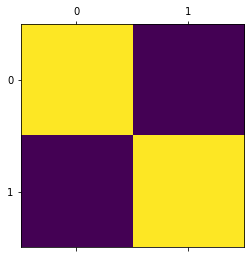

In [426]:
plt.matshow(ids_to_correlate[['cost', 'lead_time']].corr())
plt.show()

In [435]:
# Calculating correlation without removing outliers
corr = ids[['cost', 'lead_time']].corr()
corr.style.background_gradient(cmap='coolwarm')

,cost,lead_time
cost,1.000000,-0.055548
lead_time,-0.055548,1.000000


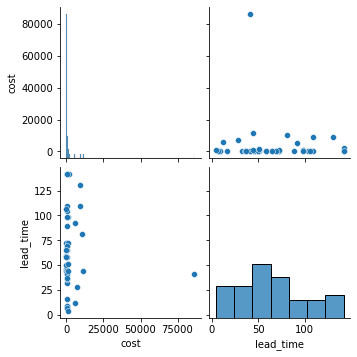

In [436]:
# Plotting correlation without removing outliers
sns.pairplot(ids[['cost', 'lead_time']]);

## Question 5

### We want to focus on reducing Lead Time of items by placing them on certain specialty programs. Which parts should we focus on?

In [118]:
ids.head()

,Item_name,Item_id,cost,lead_time
0,CABLE 1,43,34.11,71
1,CABLE 2,23,366.26,72
2,CABLE 3,38,20.19,65
3,CABLE 4,9,64.02,89
4,HEXÊNUT,39,2.50,46


In [146]:
ids.sort_values('lead_time', ascending = False).head()

,Item_name,Item_id,cost,lead_time,cost_per_day
25,CHOKE,47,57.38,142,0.404085
38,THERMO-SWITCH,24,1878.81,142,13.231056
13,ADAPTOR,16,340.08,142,2.394930
46,SHAFT,4,77.78,142,0.547746
22,CONTROLLERÊ,36,9270.45,131,70.766794


#### Products with Highest Cost per Lead Day

In [147]:
# Calculating cost per lead day
ids['cost_per_day'] = ids['cost'] / ids['lead_time']
ids.sort_values('lead_time', ascending = False).head()

,Item_name,Item_id,cost,lead_time,cost_per_day
25,CHOKE,47,57.38,142,0.404085
38,THERMO-SWITCH,24,1878.81,142,13.231056
13,ADAPTOR,16,340.08,142,2.394930
46,SHAFT,4,77.78,142,0.547746
22,CONTROLLERÊ,36,9270.45,131,70.766794


In [123]:
ids.sort_values('cost_per_day', ascending = False).head()

,Item_name,Item_id,cost,lead_time,cost_per_day
33,OXIDE GAS PANEL,45,86388.77,41,2107.043171
24,LINEARÊMOTOR,17,5701.64,12,475.136667
21,ROBOTÊINTERFACEÊMODULE,22,11270.13,44,256.139318
37,HEATER/CHILLERÊSYSTEM,27,7027.85,28,250.994643
43,PLATEÊQUARTZ,35,728.52,4,182.130000


#### Most Common Products

In [438]:
# 5 most common products
freq_prods = purchases.groupby('product_id')['id'].count().sort_values(ascending = False).reset_index().head(5)
freq_prods.rename(columns = {'id': 'id_count'}, inplace = True)
freq_prods

,product_id,id_count
0,31625,7
1,884172,7
2,696000,7
3,653800,7
4,813270,6


In [144]:
freq_prods.iloc[:, 0]

0     31625
1    884172
2    696000
3    653800
4    813270
Name: product_id, dtype: int64

In [439]:
# Purchase history of 5 most common products
purchases[purchases['product_id'].isin(freq_prods.iloc[:, 0])]

,product_id,id
8,31625,"1,43,31,37,25,32,28,35"
79,31625,"10,44,3,1,2,8,5,27,37"
702,884172,"33,6,20,13,39,22,12"
1982,696000,"22,33,32,4,27"
2720,653800,"13,35,41,26,19,12,9,43,23,32,2,36,6,17,18"
7699,31625,"46,1,19,9,22,48,44,2,10,30,6,47,42"
9268,696000,"22,2,28"
12035,31625,"20,9,2,19,29,1"
13561,884172,"39,44,45,24,12,35"
14118,696000,"23,36,38,39,22,40,42,2,27,24,46,32"


#### Future Focus Areas to Consider

* Products with the largest difference in highest and second highest leadtimes of items, presenting opportunity for substantial reduction in lead time per product (assuming work can be done concurrently on all items)
* Most commonly purchased items

## Question 6

### Cluster items based on products co-purchase history. That is, create clusters of items that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

In [176]:
updated_purchases

,product_id,id,split_ids,item_quantity
0,222087,"27,26",27,2
0,222087,"27,26",26,2
1,1343649,"6,47,17",6,3
1,1343649,"6,47,17",47,3
1,1343649,"6,47,17",17,3
...,...,...,...,...
39473,517744,"39,40,20,3,10,42,38,43,28,25,13",38,11
39473,517744,"39,40,20,3,10,42,38,43,28,25,13",43,11
39473,517744,"39,40,20,3,10,42,38,43,28,25,13",28,11
39473,517744,"39,40,20,3,10,42,38,43,28,25,13",25,11


In [190]:
purchases['split_ids'] = purchases['id'].str.split(',')

updated_purchases['split_ids'] = updated_purchases['split_ids'].astype(str)
grouped_data = updated_purchases.groupby(['product_id'])['split_ids'].apply(','.join).reset_index()
grouped_data

,product_id,split_ids
0,47,"3,4,2,13,44,16,24,28,23,45,15,46,25"
1,68,"23,10,42,39,19,6,17,25"
2,113,"46,33,30,32,43,9,38,21,15,3,25"
3,123,"4,10,27,18"
4,223,"1,6,35,29,41,45,32,17,2,22,38"
...,...,...
24880,1499730,"45,25"
24881,1499778,"32,2,42,26,14,48,6"
24882,1499797,"34,37,39,13,44,45,48,11,3,6"
24883,1499817,"21,32,42,10,44,17,47,45,8,16,2,6,2,10,48,44,38..."


In [192]:
grouped_data['ids'] = grouped_data['split_ids'].str.split(',')
grouped_data

,product_id,split_ids,ids
0,47,"3,4,2,13,44,16,24,28,23,45,15,46,25","[3, 4, 2, 13, 44, 16, 24, 28, 23, 45, 15, 46, 25]"
1,68,"23,10,42,39,19,6,17,25","[23, 10, 42, 39, 19, 6, 17, 25]"
2,113,"46,33,30,32,43,9,38,21,15,3,25","[46, 33, 30, 32, 43, 9, 38, 21, 15, 3, 25]"
3,123,"4,10,27,18","[4, 10, 27, 18]"
4,223,"1,6,35,29,41,45,32,17,2,22,38","[1, 6, 35, 29, 41, 45, 32, 17, 2, 22, 38]"
...,...,...,...
24880,1499730,"45,25","[45, 25]"
24881,1499778,"32,2,42,26,14,48,6","[32, 2, 42, 26, 14, 48, 6]"
24882,1499797,"34,37,39,13,44,45,48,11,3,6","[34, 37, 39, 13, 44, 45, 48, 11, 3, 6]"
24883,1499817,"21,32,42,10,44,17,47,45,8,16,2,6,2,10,48,44,38...","[21, 32, 42, 10, 44, 17, 47, 45, 8, 16, 2, 6, ..."


#### Reformatting Data 

In [447]:
purchases['split_ids'] = purchases['id'].str.split(',')

updated_purchases['split_ids'] = updated_purchases['split_ids'].astype(str)
grouped_data = updated_purchases.groupby(['product_id'])['split_ids'].apply(','.join).reset_index()
grouped_data['ids'] = grouped_data['split_ids'].str.split(',')
grouped_data['id_list'] = grouped_data['ids'].apply(lambda x: list(map(int, x[:-1])))
grouped_data.iloc[:, [0,3]]

,product_id,id_list
0,47,"[3, 4, 2, 13, 44, 16, 24, 28, 23, 45, 15, 46]"
1,68,"[23, 10, 42, 39, 19, 6, 17]"
2,113,"[46, 33, 30, 32, 43, 9, 38, 21, 15, 3]"
3,123,"[4, 10, 27]"
4,223,"[1, 6, 35, 29, 41, 45, 32, 17, 2, 22]"
...,...,...
24880,1499730,[45]
24881,1499778,"[32, 2, 42, 26, 14, 48]"
24882,1499797,"[34, 37, 39, 13, 44, 45, 48, 11, 3]"
24883,1499817,"[21, 32, 42, 10, 44, 17, 47, 45, 8, 16, 2, 6, 2, 10, 48, 44, 38, 23, 27, 34, 42, 24, 43, 1, 9]"


In [448]:
# Capturing number of Item IDs to loop over
unique_ids = updated_purchases['split_ids'].nunique()

# Creating column names based on Item ID
column_names = ['id'] + ['item_'+ str(i) for i in range(1, unique_ids + 1)]

# Creating empty DataFrame to fill
purchases_transformed = pd.DataFrame(columns = column_names)

# Converting grouped dataset into DataFrame that can be used for clustering
for i in range(len(grouped_data)):
    
    items_list = grouped_data.id_list[i]
    table_columns = [grouped_data.product_id[i]]
    
    for j in range(1, unique_ids + 1):
        
        # Set count to 0
        count = 0
        
        # If item exist in 1 product, add 1
        for item in items_list:
            if item == j:
                count += 1
        
        # Add count of items to table
        table_columns.append(count)
        
    purchases_transformed = purchases_transformed.append(pd.Series(row,index = column_names), ignore_index = True)

purchases_transformed.head()

,id,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,...,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48
0,1499974,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1499974,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1499974,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1499974,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1499974,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [205]:
# Capturing number of Item IDs to loop over
unique_ids = updated_purchases['split_ids'].nunique()

# Creating column names based on Item ID
column_names = ['id'] + ['item_'+ str(i) for i in range(1, unique_ids + 1)]

# Creating empty DataFrame to fill
purchases_transformed = pd.DataFrame(columns = column_names)

# Converting grouped dataset into DataFrame that can be used for clustering
for i in range(len(grouped_data)):
    
    items_list = grouped_data.id_list[i]
    table_columns = [grouped_data.product_id[i]]
    
    for j in range(1, unique_ids + 1):
        
        # Set count to 0
        count = 0
        
        # If item exist in 1 product, add 1
        for item in items_list:
            if item == j:
                count += 1
        
        # Add count of items to table
        table_columns.append(count)
        
    purchases_transformed = purchases_transformed.append(pd.Series(row,index = column_names), ignore_index = True)

# Original
purchases_transformed.tail()

,id,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,...,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48
24880,1499730,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
24881,1499778,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
24882,1499797,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,1
24883,1499817,1,2,0,0,0,1,0,1,1,...,0,0,0,2,1,2,1,0,1,1
24884,1499974,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
# Removing Product ID column
purchases_transformed.drop('id', axis = 1, inplace = True)

# Transposing DataFrame so that Item IDs populate rows
purchases_to_cluster = purchases_transformed.T

# Items IDs x Product IDs
purchases_to_cluster

,0,1,2,3,4,5,6,7,8,9,...,24875,24876,24877,24878,24879,24880,24881,24882,24883,24884
item_1,0,0,0,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
item_2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
item_3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
item_4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
item_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
item_6,0,1,0,0,1,0,1,0,0,0,...,0,1,1,1,0,0,0,0,1,0
item_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
item_8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
item_9,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
item_10,0,1,0,1,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,2,1


In [214]:
# Defining function to perform K-Means clustering
def fit_kmeans(df, n):
    
    kmeans = KMeans(n_clusters = n)
    kmeans.fit(df)
    
    return kmeans

#### Defining optimal number of clusters

In [268]:
# Calculating SSE for all possible values of K

k_values = range(1, len(purchases_to_cluster) + 1)

# Sum of squared errors
sse_values = []

for k in k_values:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(purchases_to_cluster)
    
    # Calculating SSE
    sse = kmeans.inertia_
    
    # Adding calcualting SSE to array of all SSE values
    sse_values.append(sse)

C:\Users\gpurtell163180\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [473]:
pd.DataFrame(data = {'k_value': k_values, 'sse': sse_values})

,k_value,sse
0,1,243350.041667
1,2,230741.809524
2,3,218699.578947
3,4,211988.805556
4,5,203854.455556
5,6,203638.276423
6,7,197462.782051
7,8,190394.377193
8,9,182905.166667
9,10,175533.805556


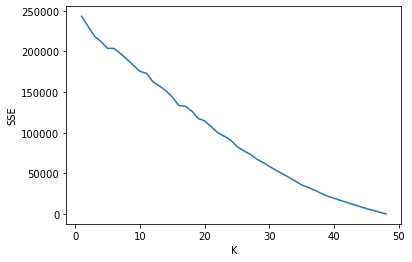

In [271]:
# Attempting to identify optimal number of clusters by finding elbow point
plt.plot(k_values, sse_values)
plt.xlabel('K')
plt.ylabel('SSE')
plt.show();

In [452]:
# We will use 11 as number of clusters
kmeans = fit_kmeans(purchases_to_cluster, 11)
kmeans

KMeans(n_clusters=11)

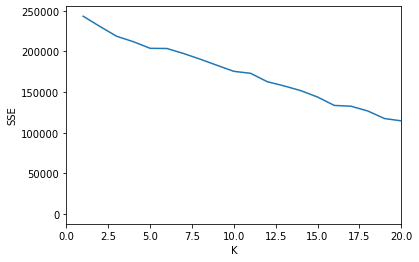

In [451]:
# Increase zoom on 0 <= K <= 20
plt.plot(k_values, sse_values)
plt.xlim([0, 20])
plt.xlabel('K')
plt.ylabel('SSE')
plt.show();

#### Results

In [459]:
# Creating table of assigned clusters

# No need to remove outliers (identified outlier is outlier for cost/rpice)
clusters_per_id = pd.DataFrame()

clusters_per_id['Item_ID'] = purchases_to_cluster.index.values
clusters_per_id['Cluster'] = kmeans.labels_

clusters_per_id

,Item_ID,Cluster
0,item_1,7
1,item_2,5
2,item_3,0
3,item_4,0
4,item_5,0
5,item_6,1
6,item_7,0
7,item_8,0
8,item_9,6
9,item_10,3


In [460]:
clusters_per_id['ID'] = cluster_map['Item_ID'].str.split('_').str[1].astype(int)
clusters_per_id.head()

,Item_ID,Cluster,ID
0,item_1,7,1
1,item_2,5,2
2,item_3,0,3
3,item_4,0,4
4,item_5,0,5


In [477]:
clusters_per_id.groupby(['Cluster'])['Item_ID'].count().reset_index()

,Cluster,Item_ID
0,0,32
1,1,2
2,2,3
3,3,2
4,4,1
5,5,1
6,6,2
7,7,1
8,8,1
9,9,1


In [482]:
clusters_per_id.sort_values(['Cluster', 'ID'])

,Item_ID,Cluster,ID
2,item_3,0,3
3,item_4,0,4
4,item_5,0,5
6,item_7,0,7
7,item_8,0,8
10,item_11,0,11
11,item_12,0,12
13,item_14,0,14
14,item_15,0,15
15,item_16,0,16


#### Merging Data

In [280]:
ids.head(2)

,Item_name,Item_id,cost,lead_time,cost_per_day
0,CABLE 1,43,34.11,71,0.480423
1,CABLE 2,23,366.26,72,5.086944


In [462]:
clustered_results = ids.merge(clusters_per_id, left_on = 'Item_id', right_on = 'ID')
clustered_results.head()

,Item_name,Item_id,cost,lead_time,cost_per_day,cost_zscore,lead_time_zscore,Item_ID,Cluster,ID
0,CABLE 1,43,34.11,71,0.480423,-0.26,0.19,item_43,10,43
1,CABLE 2,23,366.26,72,5.086944,-0.23,0.22,item_23,10,23
2,CABLE 3,38,20.19,65,0.310615,-0.26,0.03,item_38,6,38
3,CABLE 4,9,64.02,89,0.719326,-0.26,0.66,item_9,6,9
4,HEXÊNUT,39,2.50,46,0.054348,-0.26,-0.47,item_39,0,39


#### Visualizing Results

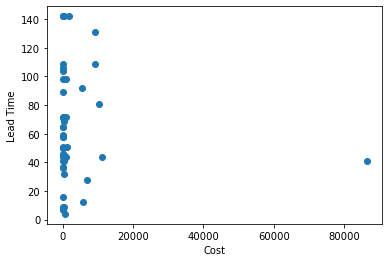

In [463]:
plt.scatter(clustered_results.iloc[:, 2], clustered_results.iloc[:, 3])
plt.xlabel('Cost')
plt.ylabel('Lead Time')
plt.show();

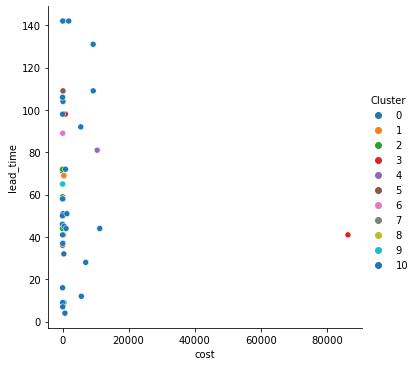

In [471]:
# Plot with outliers
sns.relplot(data = clustered_results, x = clustered_results.iloc[:, 2], y = clustered_results.iloc[:, 3], hue = clustered_results['Cluster'], palette = "tab10");

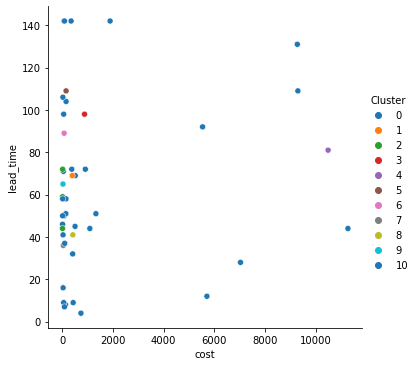

In [466]:
# Plot without outliers
sns.relplot(data = clustered_results[clustered_results['cost'] < 60000], x = clustered_results[clustered_results['cost'] < 60000].iloc[:, 2], y = clustered_results[clustered_results['cost'] < 60000].iloc[:, 3], hue = clustered_results['Cluster'], palette = "tab10");

#### Future Approaches to Consider
* For K-Means clustering, use Silhouette method to identify optimal number of clusters. Silhouette score evaluates the quality of clusters created (as opposed to using elbow method with SSE)
* Density clustering (DBSCAN) to cluster items, this approach does not require a number of clusters as a parameter